1. Initial Import

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (InputLayer, Flatten, Dense, Conv2D,
                                     MaxPool2D, Dropout, BatchNormalization)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from google.colab.patches import cv2_imshow

In [7]:

# === MOUNT GOOGLE DRIVE ===
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [8]:

# === LOAD DATASET ===
imagePaths = '/content/drive/MyDrive/Data/DatasetDaun/'
label_list = ['Nangka', 'Daun Sirih']
data = []
labels = []

In [9]:

for label in label_list:
    image_dir = imagePaths+'/'+label+'/*.jpg'
    print(f"[+] Mencari gambar di: {image_dir}")
    for imagePath in glob.glob(image_dir):
        image = cv2.imread(imagePath)
        image = cv2.resize(image, (32, 32))
        data.append(image)
        labels.append(label)


[+] Mencari gambar di: /content/drive/MyDrive/Data/DatasetDaun//Nangka/*.jpg
[+] Mencari gambar di: /content/drive/MyDrive/Data/DatasetDaun//Daun Sirih/*.jpg


In [11]:

# === PREPROCESS DATA ===
data = np.array(data, dtype='float') / 255.0
labels = np.array(labels)

lb = LabelEncoder()
labels = lb.fit_transform(labels)

x_train, x_test, y_train, y_test = train_test_split(
    data, labels, test_size=0.2, random_state=42)


In [12]:

print('Ukuran data train =', x_train.shape)
print('Ukuran data test =', x_test.shape)


Ukuran data train = (81, 32, 32, 3)
Ukuran data test = (21, 32, 32, 3)


In [13]:

# === MODEL CNN ===
model = Sequential([
    InputLayer(input_shape=(32, 32, 3)),
    Conv2D(32, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPool2D(2,2, padding='same'),

    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPool2D(2,2, padding='same'),
    Dropout(0.25),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [14]:

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,117,953 (8.08 MB)

 Trainable params: 2,117,761 (8.08 MB)

 Non-trainable params: 192 (768.00 B)

In [15]:

# === CALLBACKS ===
callbacks = [
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=1),
    ModelCheckpoint('/content/best_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
]

In [16]:

# === KOMPILE MODEL ===
lr = 0.001
max_epochs = 50
opt_funct = Adam(learning_rate=lr)

model.compile(loss='binary_crossentropy',
              optimizer=opt_funct,
              metrics=['accuracy'])


In [21]:

# === DATA AUGMENTATION ===
datagen = ImageDataGenerator(
    rotation_range=25,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.1,
    zoom_range=0.25,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(x_train)

In [22]:

# === TRAINING ===
H = model.fit(
    datagen.flow(x_train, y_train, batch_size=32),
    validation_data=(x_test, y_test),
    epochs=max_epochs,
    callbacks=callbacks
)


Epoch 1/50
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9375 - loss: 0.3292

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.9191 - loss: 0.3145 
Epoch 1: val_accuracy did not improve from 0.38095
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.9177 - loss: 0.3121 - val_accuracy: 0.3810 - val_loss: 0.6938 - learning_rate: 6.2500e-05
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.9176 - loss: 0.3144
Epoch 2: val_accuracy did not improve from 0.38095
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 220ms/step - accuracy: 0.9166 - loss: 0.3070 - val_accuracy: 0.3810 - val_loss: 0.6939 - learning_rate: 6.2500e-05
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.8551 - loss: 0.3325
Epoch 3: val_accuracy did not improve from 0.38095
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step - accuracy: 0.8574 - loss: 0.3320 - val_accuracy: 0.3810 - val_loss: 0.6936 - learning_rate: 6.2500e-05
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.9243 - loss: 0.2573
Epoch 4: val_accuracy did not improve from 0.38095
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - a

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 259ms/step - accuracy: 0.9046 - loss: 0.2535 - val_accuracy: 0.5714 - val_loss: 0.6923 - learning_rate: 3.1250e-05
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.9079 - loss: 0.2592 
Epoch 9: val_accuracy improved from 0.57143 to 0.76190, saving model to /content/best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step - accuracy: 0.8970 - loss: 0.2670 - val_accuracy: 0.7619 - val_loss: 0.6921 - learning_rate: 3.1250e-05
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9098 - loss: 0.2301
Epoch 10: val_accuracy improved from 0.76190 to 1.00000, saving model to /content/best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9076 - loss: 0.2300 - val_accuracy: 1.0000 - val_loss: 0.6918 - learning_rate: 3.1250e-05
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.9285 - loss: 0.2112
Epoch 11: val_accuracy did not improve from 1.00000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 0.9278 - loss: 0.2140 - val_accuracy: 0.8095 - val_loss: 0.6915 - learning_rate: 3.1250e-05
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.8592 - loss: 0.2915
Epoch 12: val_accuracy did not improve from 1.00000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.8635 - loss: 0.2949 - val_accuracy: 0.7143 - val_loss: 0.6910 - learning_rate: 3.1250e-05
Epoch 13/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9419 - loss: 0.1882
Epoch 13: val_accuracy did not improve from 1.00000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.9441 - loss: 0.1854 - val_accuracy: 0.6190 - val_loss: 0.6906 - learning_rate: 3.1250e-05
Epoch 14/50
3/3 ━━━━

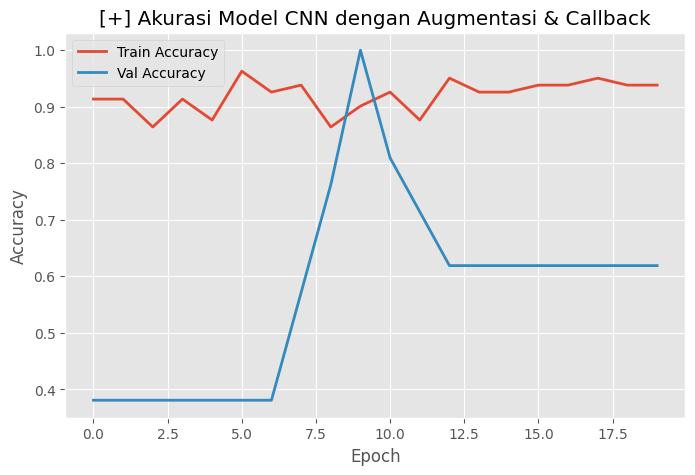

In [23]:

# === PLOT AKURASI ===
plt.style.use("ggplot")
plt.figure(figsize=(8,5))
plt.plot(H.history["accuracy"], label="Train Accuracy", linewidth=2)
plt.plot(H.history["val_accuracy"], label="Val Accuracy", linewidth=2)
plt.title("[+] Akurasi Model CNN dengan Augmentasi & Callback")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

In [24]:

# === EVALUASI MODEL ===
predictions = (model.predict(x_test) > 0.5).astype(int)
print("\n=== Classification Report ===")
print(classification_report(y_test, predictions, target_names=label_list))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step

=== Classification Report ===
              precision    recall  f1-score   support

      Nangka       1.00      1.00      1.00         8
  Daun Sirih       1.00      1.00      1.00        13

    accuracy                           1.00        21
   macro avg       1.00      1.00      1.00        21
weighted avg       1.00      1.00      1.00        21



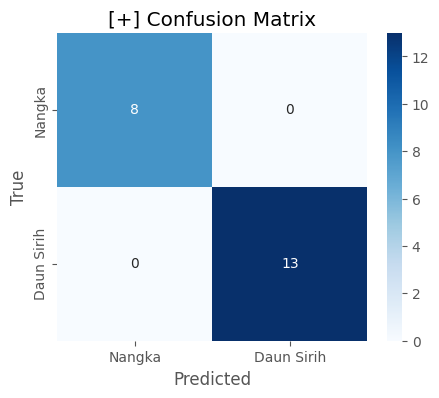

In [26]:

# === CONFUSION MATRIX ===
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_list, yticklabels=label_list)
plt.title("[+] Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [27]:

# === TEST PREDIKSI ===
def predict_image(path):
    img = cv2.imread(path)
    output = img.copy()
    img = cv2.resize(img, (32, 32))
    img = np.expand_dims(img, axis=0).astype('float') / 255.0
    pred = model.predict(img)[0][0]
    label = "Nangka" if pred > 0.5 else "Daun Sirih"
    cv2.putText(output, f"Prediction: {label}", (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)
    print(f"{path} -> {label} ({pred:.4f})")
    cv2_imshow(output)



[+] Uji Gambar Daun Nangka:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
/content/drive/MyDrive/Data/DatasetDaun//Nangka/019.jpg -> Nangka (0.6054)


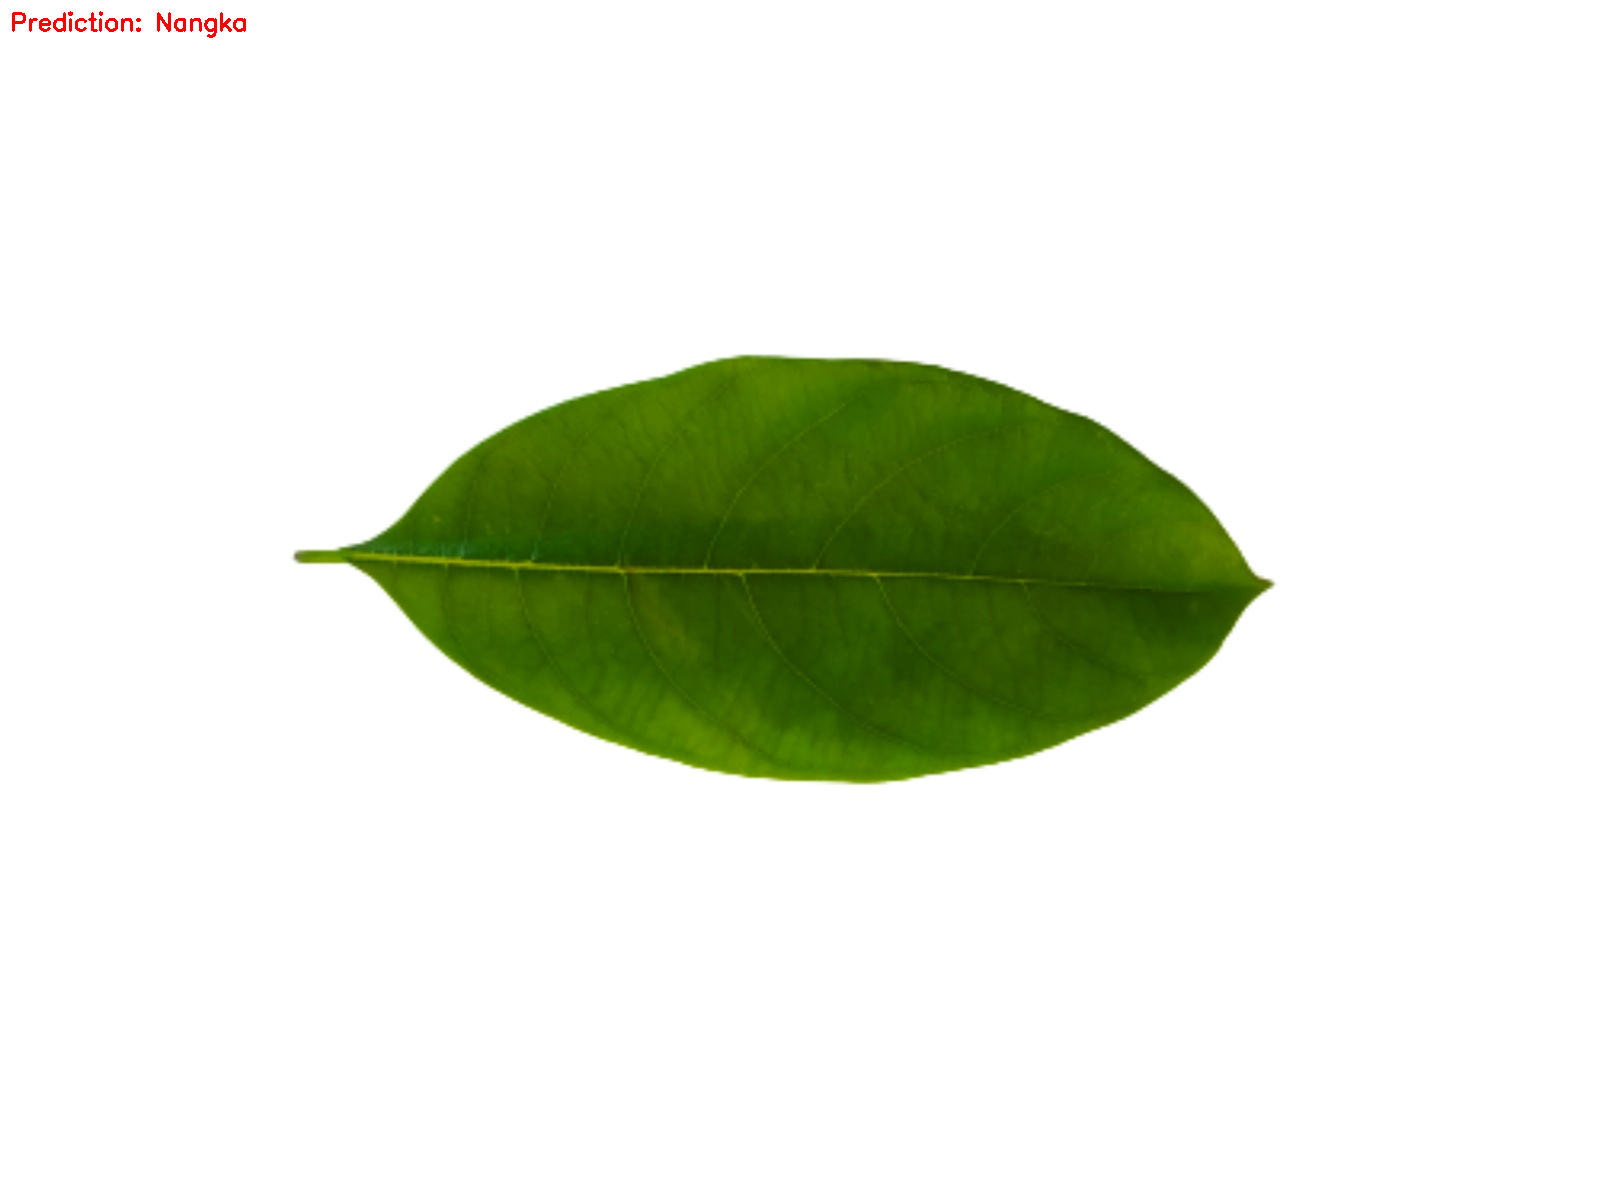


[+] Uji Gambar Daun Sirih:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
/content/drive/MyDrive/Data/DatasetDaun//Daun Sirih/019.jpg -> Daun Sirih (0.3000)


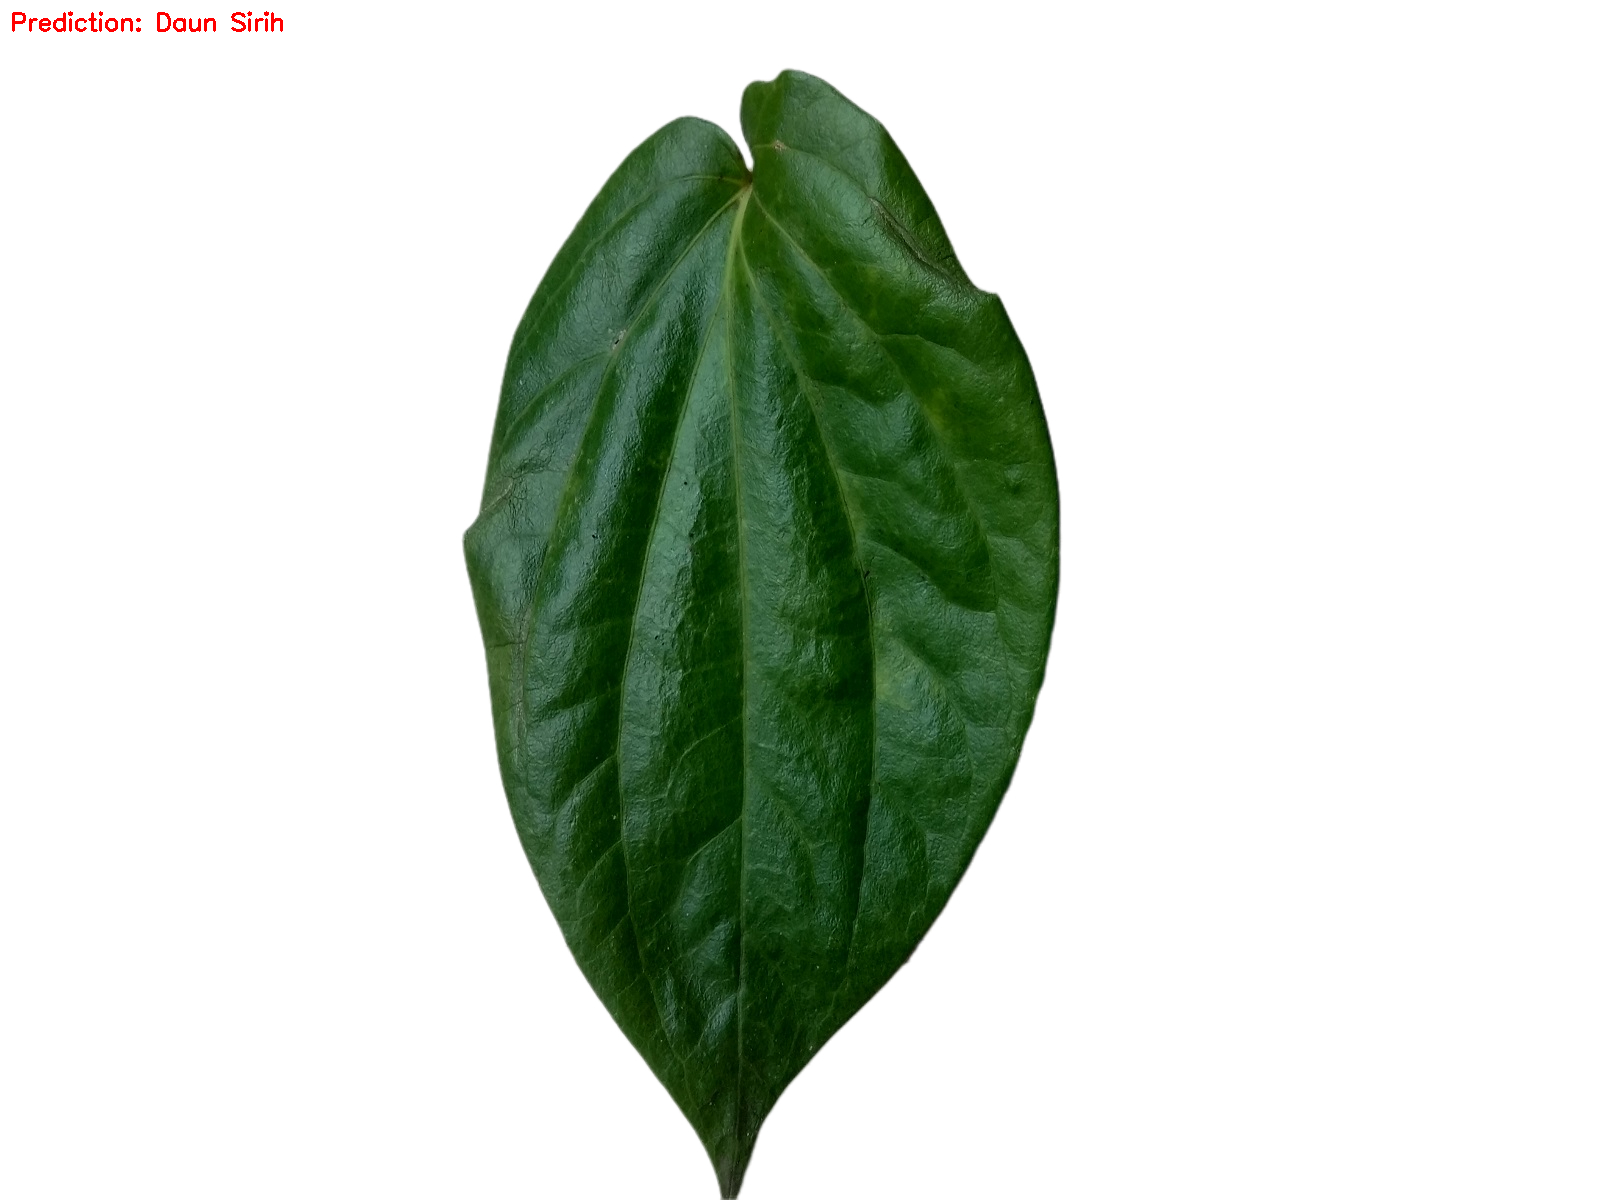

In [28]:

print("\n[+] Uji Gambar Daun Nangka:")
predict_image(imagePaths+'/Nangka/019.jpg')

print("\n[+] Uji Gambar Daun Sirih:")
predict_image(imagePaths+'/Daun Sirih/019.jpg')